'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


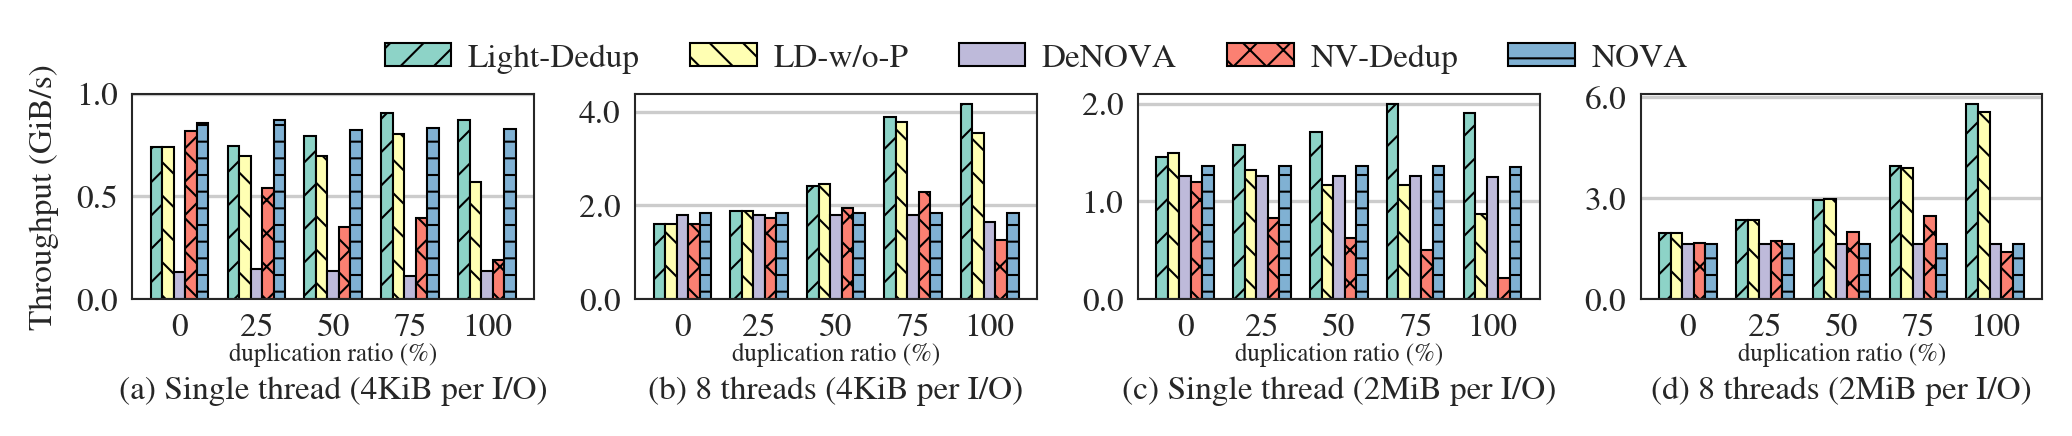

In [4]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.8
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table-4K", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

with open("./performance-comparison-table-continuous", "r") as f:
    df_cons = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

rows = df.shape[0]
cols = df.shape[1]

df_low = df[df['num_job'] == 1].drop(columns=['num_job'])
df_mid = df[df['num_job'] == 8].drop(columns=['num_job'])
df_high = df[df['num_job'] == 16].drop(columns=['num_job'])
df_cons_low = df_cons[df_cons['num_job'] == 1].drop(columns=['num_job'])
df_cons_mid = df_cons[df_cons['num_job'] == 8].drop(columns=['num_job'])
df_cons_high = df_cons[df_cons['num_job'] == 16].drop(columns=['num_job'])

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(3.5)))
gs1 = gridspec.GridSpec(1, 4)
# gs1.update(hspace=0.2) # set the spacing between axes.

bar_width = 0.15
# subfig_titles = ["(a) 0% dup ratio", "(b) 25% dup ratio", "(c) 50% dup ratio", "(d) 75% dup ratio"]
# subfig_titles = ["(a) Low concurrency (4KiB per I/O)", "(b) Medium concurrency (4KiB per I/O)", "(c) High concurrency (4KiB per I/O)", "(d) Low concurrency (2MiB per I/O)", "(e) Medium concurrency (2MiB per I/O)", "(f) High concurrency (2MiB per I/O)"]
subfig_titles = ["(a) Single thread (4KiB per I/O)", "(b) 8 threads (4KiB per I/O)", "(c) Single thread (2MiB per I/O)", "(d) 8 threads (2MiB per I/O)"]
patterns = ['///', '\\\\\\', '', 'XXX', '---']
# Reference: https://designbro.com/blog/inspiration/color-combinations/
colors = ["#FFE8B2", "#82EACF", "#88C4D8", "#FFBFBF", "#F3F3F3"]

# dfs = [df_dup0, df_dup25, df_dup50, df_dup75]
# dfs = [df_low, df_mid, df_high, df_cons_low, df_cons_mid, df_cons_high]
dfs = [df_low, df_mid, df_cons_low, df_cons_mid]
for i in range(len(dfs)):
    subfig = plt.subplot(gs1[i])
    df = dfs[i]
    x = [1, 2, 3, 4, 5]
    x_label = df['dup_rate'].drop_duplicates().reset_index().drop(columns=['index'])['dup_rate']
    fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
    tot = len(fss) * bar_width
    max_value_int = 0
    for idx, fs in enumerate(fss):
        points = []
        for pivot in x:
            point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
            points.append(point)
        plt.bar(points, df[df['file_system'] == fs]['bandwidth(MiB/s)'] / 1024, width=bar_width, hatch=patterns[idx], edgecolor='black', color=plt.get_cmap('Set3')(idx), linewidth=0.5)
        max_value = (df[df['file_system'] == fs]['bandwidth(MiB/s)'] / 1024).max()
        if round(max_value) > max_value_int:
            max_value_int = round(max_value)
            
    plt.yticks([0, max_value_int / 2, max_value_int], fontsize=8)
    plt.xticks(x, labels=x_label, fontsize=8)

    # Draw title
    subfig.text(0.5, -0.27, "duplication ratio (%)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
    if i == 0:
        plt.ylabel('Throughput (GiB/s)', fontsize=8)
    plt.xlabel(subfig_titles[i], labelpad = 8, fontsize=8) 
    ax = fig.gca()
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
            
fig.legend(fss.map({
    "Light-Dedup": "Light-Dedup",
    "Naive": "LD-w/o-P",
    "DeNOVA": "DeNOVA",
    "NV-Dedup": "NV-Dedup",
    "NOVA": "NOVA"
}), loc='center', bbox_to_anchor=(0.5, 0.95), ncol=len(fss), fontsize=8, columnspacing=1.5, handletextpad=0.5,  labelspacing=0.5)
# fig.legend(fss, loc='center', bbox_to_anchor=(0.5, 0.95), ncol=3, fontsize=8, frameon=False, columnspacing=1.5, handletextpad=0.5,  labelspacing=0.5)

plt.tight_layout()
plt.savefig("./FIG-FIO.pdf", bbox_inches='tight', pad_inches=0)
